In [136]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from peewee import MySQLDatabase
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import json
from janitor import clean_names, remove_empty
import re

In [5]:
!pip install pyarrow

You should consider upgrading via the '/opt/jupyterhub/bin/python3 -m pip install --upgrade pip' command.


In [18]:
%matplotlib inline  

In [2]:
def count_limit_plot(input_df, plot_dim, first_n = 10):
    
    plot_obj = input_df[[plot_dim]]
    plot_obj_first_n_list = plot_obj[plot_dim].value_counts().index[:first_n].to_list()

    lkp_df = pd.DataFrame({plot_dim:plot_obj_first_n_list, 'lkp':plot_obj_first_n_list})
    plot_obj_merge=plot_obj.merge(lkp_df, how='left', on=plot_dim)
    plot_obj_merge['lkp'] = plot_obj_merge.lkp.fillna('OTH')

    sort_index = plot_obj_merge.loc[plot_obj_merge.lkp!='OTH']['lkp'].value_counts().index.to_list()
    sort_index += ['OTH']

    sns.catplot(x='lkp',  
                kind = 'count', 
                data = plot_obj_merge,
                order=sort_index
               ).fig.set_size_inches(25,5)
    
    pass  
    

In [52]:
def get_sorted_level(df, key, sort_col):

    return df.groupby(key)[sort_col].median().sort_values().index

In [3]:
config = {
  'user': 'scraper',
  'password': 's:a6:sFcNP^:A',
  'host': '212.237.39.83',
  'database': 'immo_data'
}

cnx = MySQLDatabase('immo_data', 
                   user='scraper', 
                   password='s:a6:sFcNP^:A',
                   host='212.237.39.83', 
                   port=3306)

In [4]:
annuncio = pd.read_sql('select * from annuncio', cnx)
dettaglio = pd.read_sql('select * from dettaglio', cnx)
reversegeo = pd.read_sql('select * from reversegecodingad', cnx)

/opt/jupyterhub/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/jupyterhub/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/jupyterhub/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [10]:
os.listdir()

['main.py', 'main_eda_notebook.ipynb', 'immobiliare-v2', '.ipynb_checkpoints']

In [11]:
annuncio.to_parquet('immobiliare-v2/data/input/annuncio.parquet')
dettaglio.to_parquet('immobiliare-v2/data/input/dettaglio.parquet')
reversegeo.to_parquet('immobiliare-v2/data/input/reversegeo.parquet')

merge_dataset = pd.merge(annuncio, dettaglio, on='url_id', suffixes=('_ann', '_dett'))
merge_dataset = pd.merge(merge_dataset, reversegeo, on='url_id', suffixes=('', '_rga'))

merge_dataset.to_parquet('immobiliare-v2/data/input/merge_dataset.parquet')

In [12]:
cnx.close()

True

In [13]:
annuncio = pd.read_parquet('immobiliare-v2/data/input/annuncio.parquet')
dettaglio = pd.read_parquet('immobiliare-v2/data/input/dettaglio.parquet')
merge_dataset = pd.read_parquet('immobiliare-v2/data/input/merge_dataset.parquet')

In [14]:
merge_dataset['euro_mq'] = merge_dataset['prezzo'] / merge_dataset['superficie']

In [16]:
merge_dataset.shape

(260326, 56)

In [15]:
merge_dataset.head(1).T
merge_dataset.dtypes

id_ann                           int64
regione                         object
provincia                       object
comune                          object
url_ann                         object
url_id                          object
parent_url                      object
affitto                          int64
data_prima_presenza_online      object
data_ultima_presenza_online     object
data_run                        object
id_dett                          int64
url_dett                        object
indirizzo                       object
latitudine                     float64
longitudine                    float64
titolo                          object
sottotitolo                     object
descrizione_breve               object
descrizione                     object
data_inserimento                object
tipo_immobile                   object
tipo_proprietà                  object
prezzo                         float64
spese_condominio               float64
rendita                  

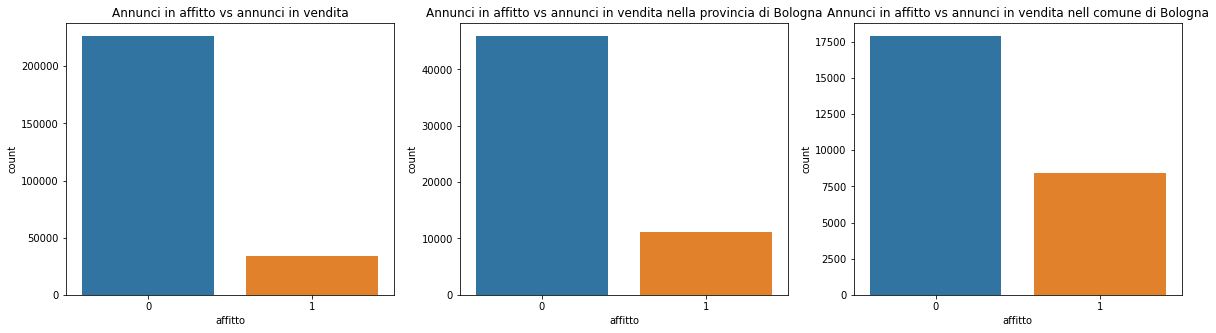

In [20]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
sns.countplot('affitto', 
              data=merge_dataset, 
              ax = axs[0]
             ).set(title='Annunci in affitto vs annunci in vendita')

sns.countplot('affitto', 
              data=merge_dataset.loc[merge_dataset.sigla =='BO'], 
              ax=axs[1]
             ).set(title='Annunci in affitto vs annunci in vendita nella provincia di Bologna')

sns.countplot('affitto', 
              data=merge_dataset.loc[merge_dataset.comune_rga =='Bologna'], 
              ax = axs[2]
             ).set(title='Annunci in affitto vs annunci in vendita nell comune di Bologna')
plt.show()

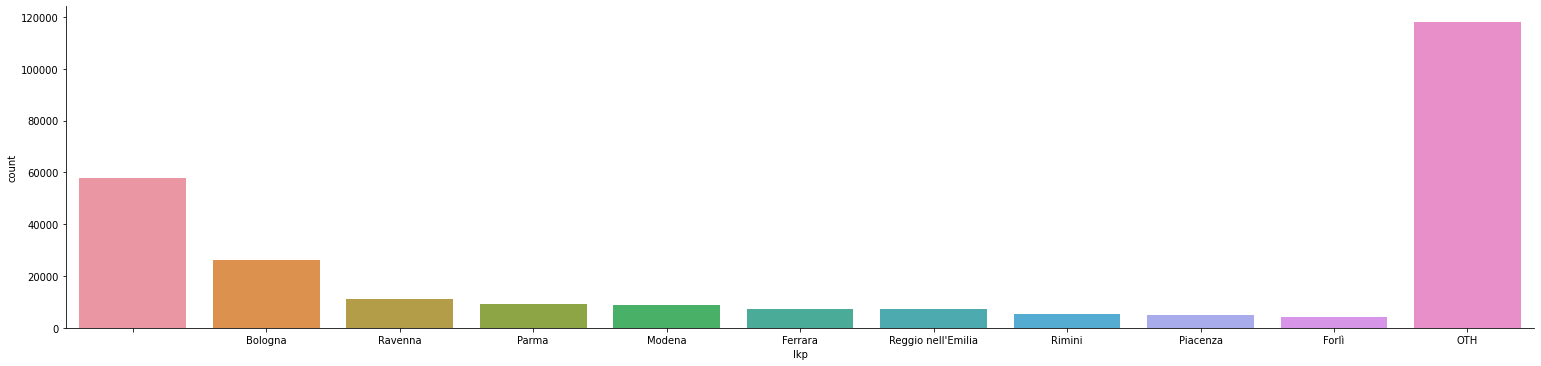

In [21]:
count_limit_plot(merge_dataset,'comune_rga')

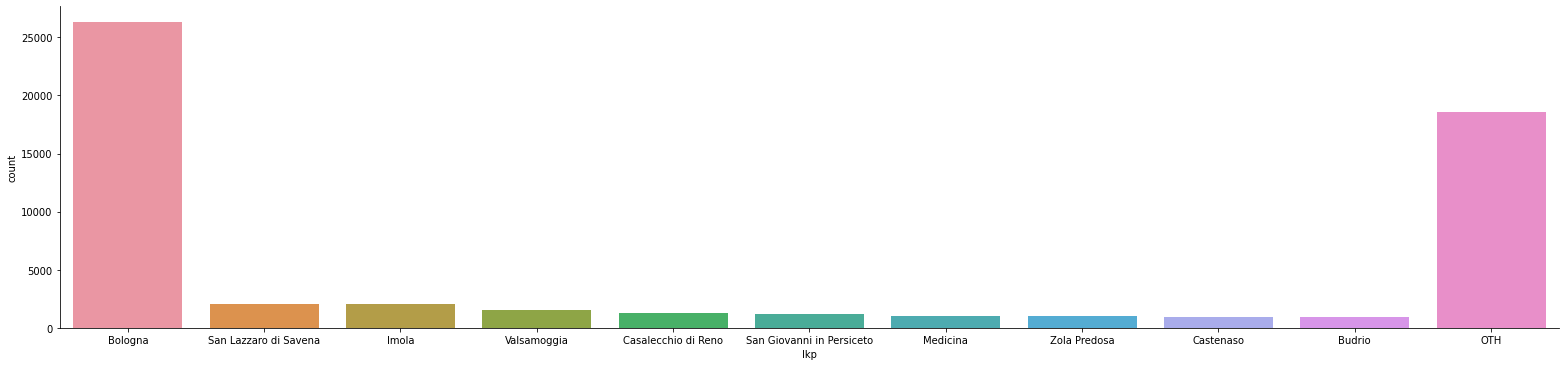

In [22]:
count_limit_plot(merge_dataset.loc[merge_dataset.sigla =='BO'],'comune_rga')

In [23]:
bologna = merge_dataset.loc[merge_dataset.comune_rga =='Bologna']

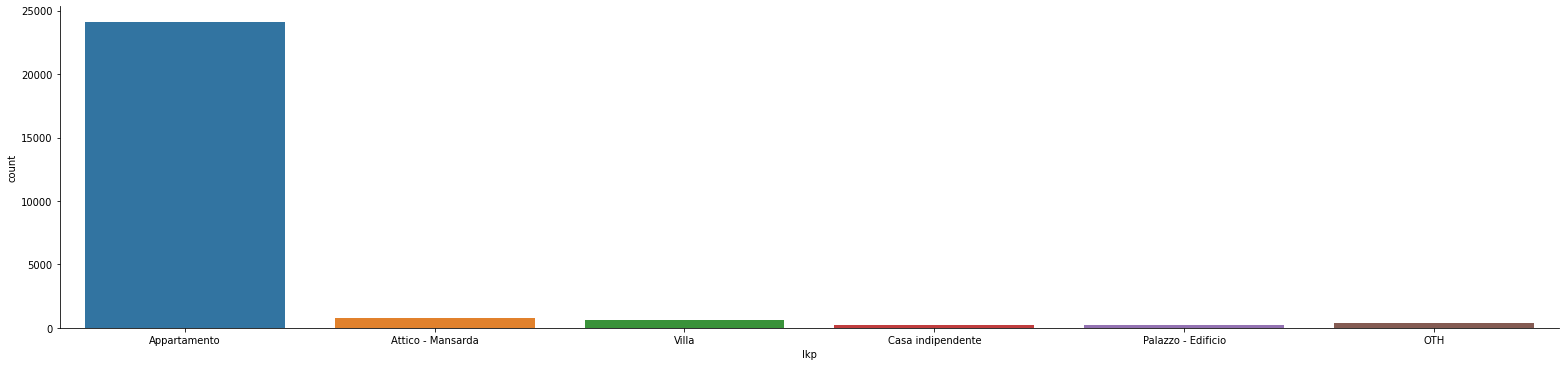

In [24]:
count_limit_plot(bologna,'tipo_immobile', 5)

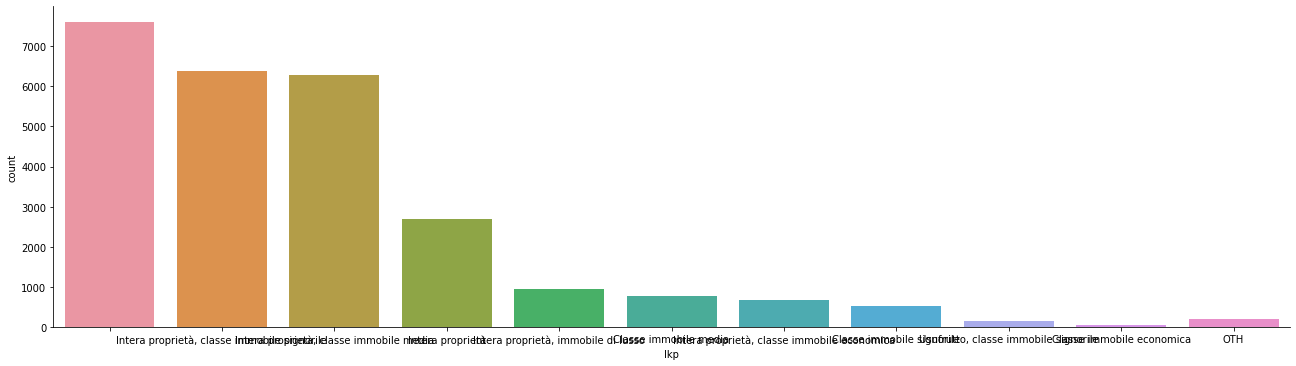

In [25]:
count_limit_plot(bologna,'tipo_proprietà')

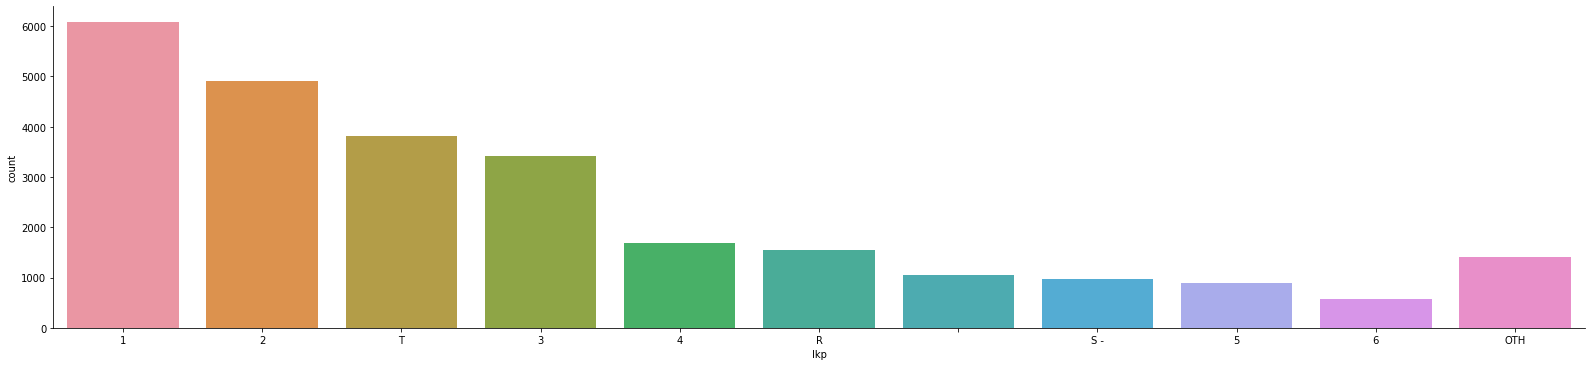

In [26]:
count_limit_plot(bologna,'piano')

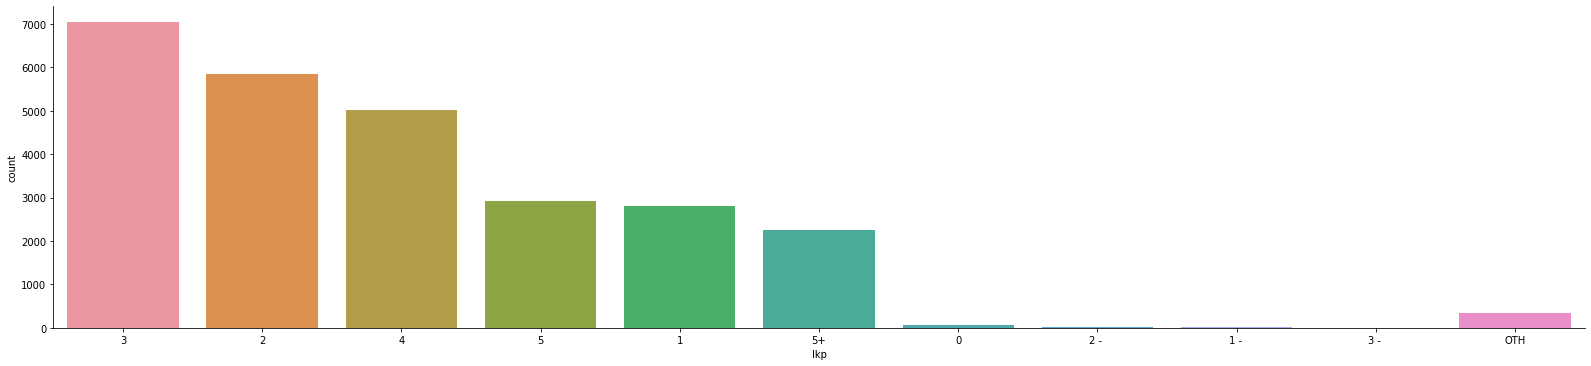

In [27]:
count_limit_plot(bologna,'locali')

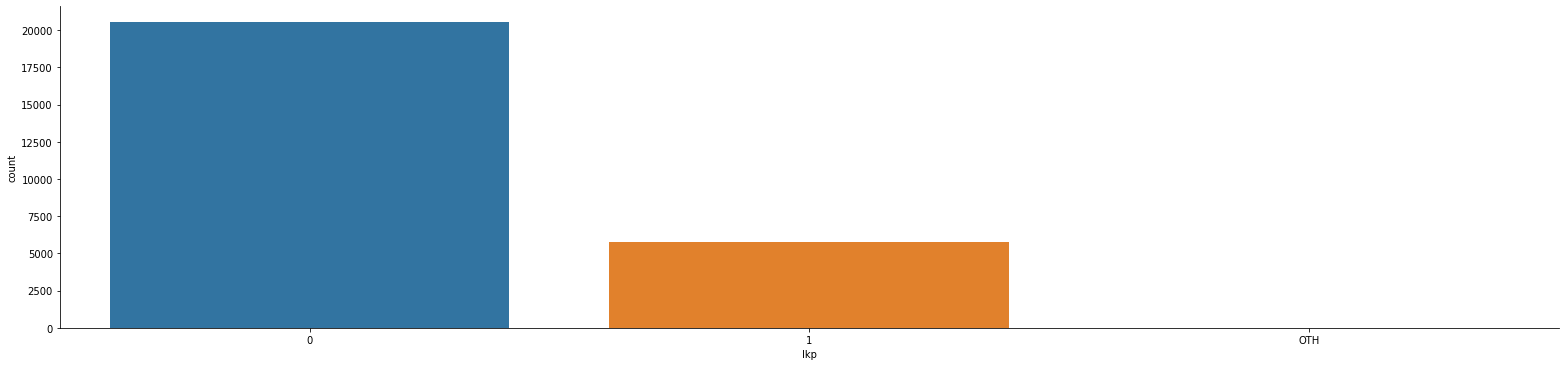

In [28]:
count_limit_plot(bologna,'climatizzato')

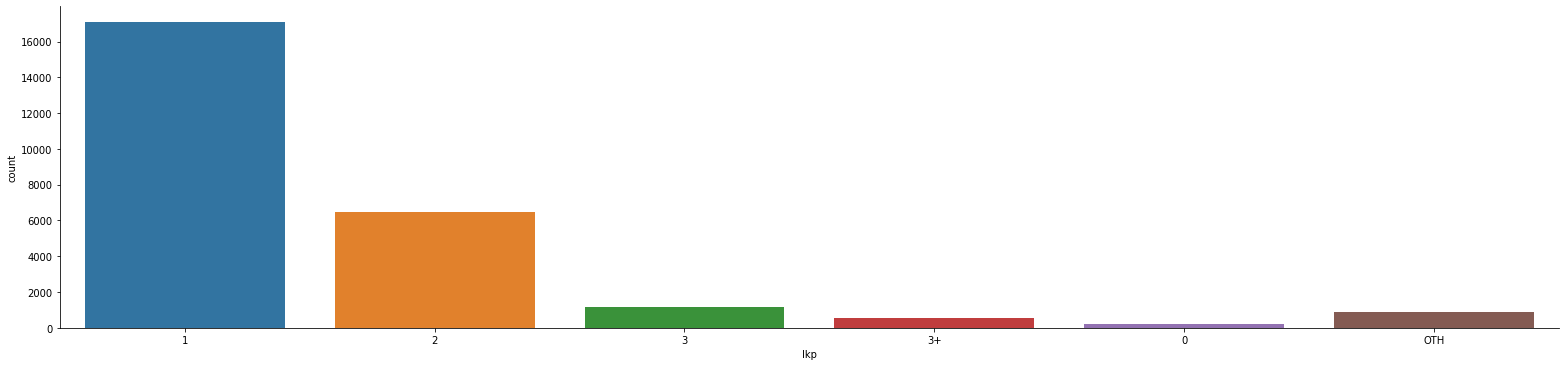

In [29]:
count_limit_plot(bologna,'bagni')

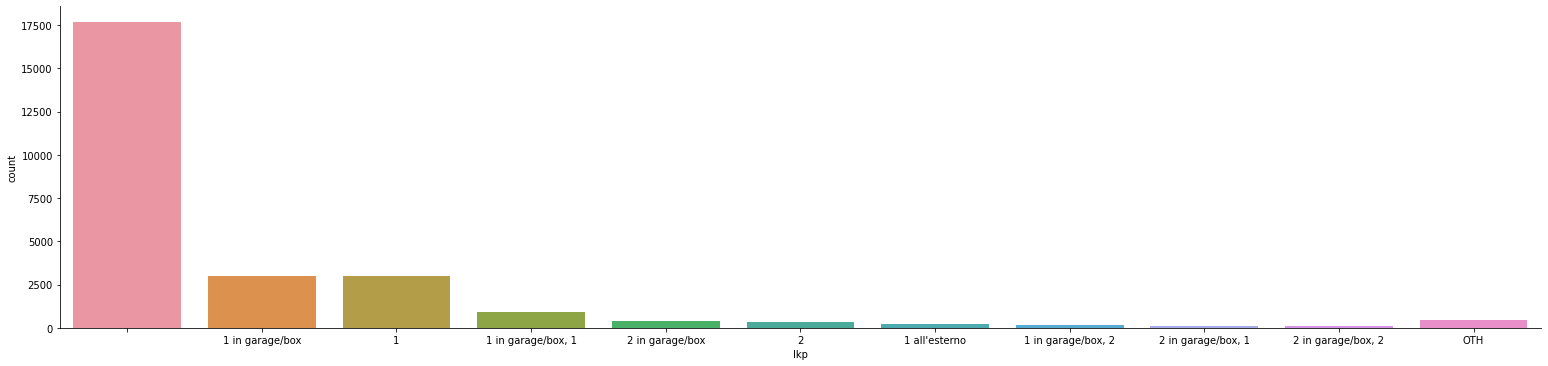

In [30]:
count_limit_plot(bologna,'posto_auto')

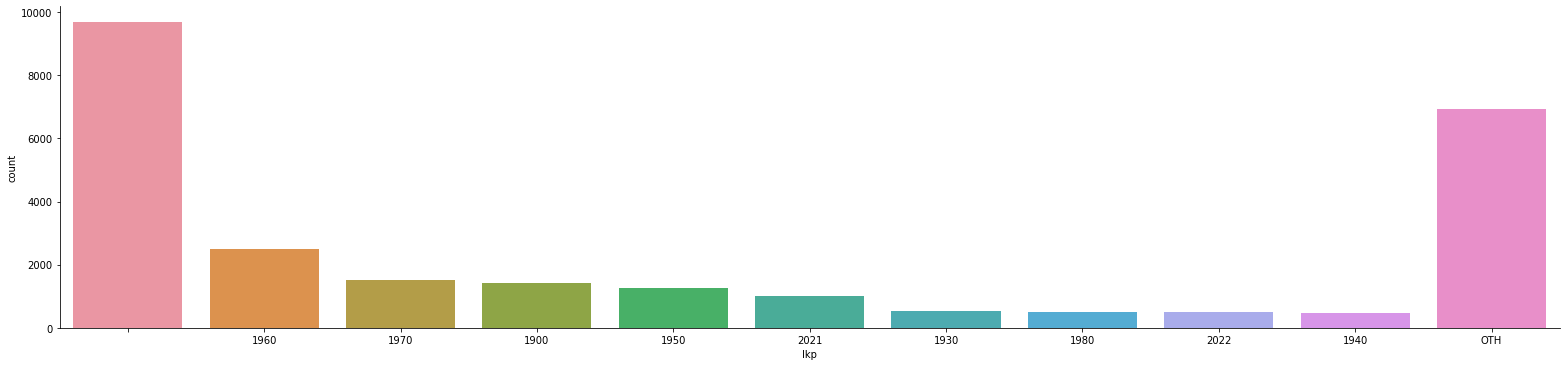

In [31]:
count_limit_plot(bologna,'anno_costruzione')

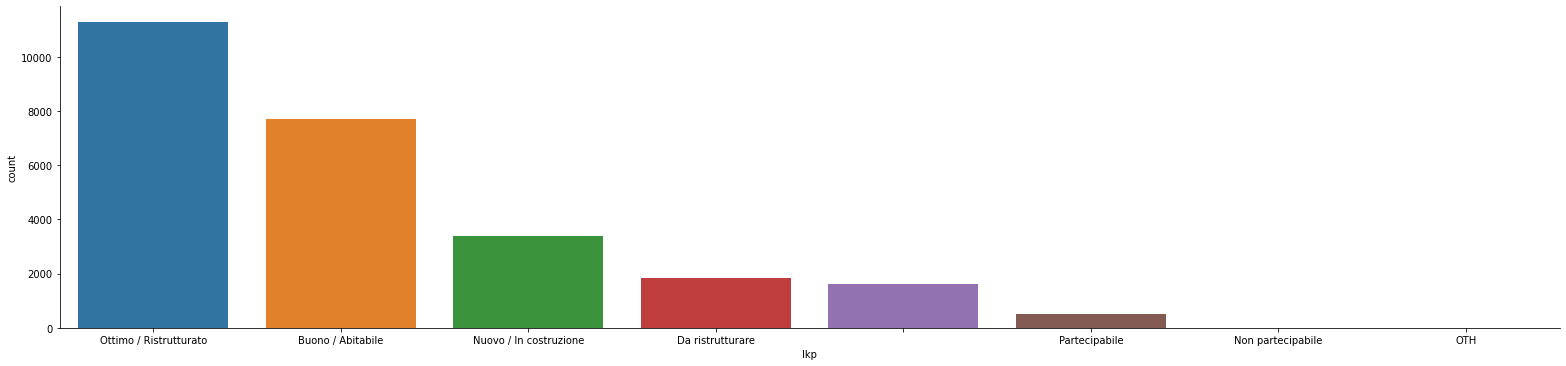

In [32]:
count_limit_plot(bologna,'stato')

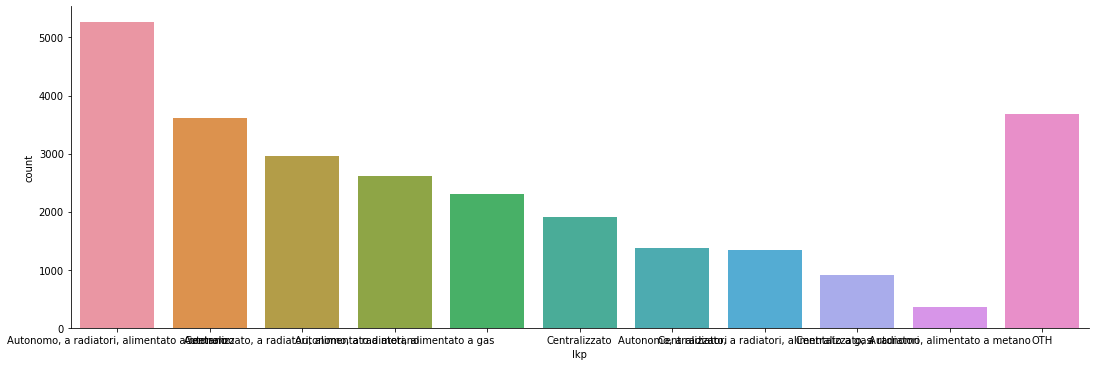

In [33]:
count_limit_plot(bologna,'riscaldamento')

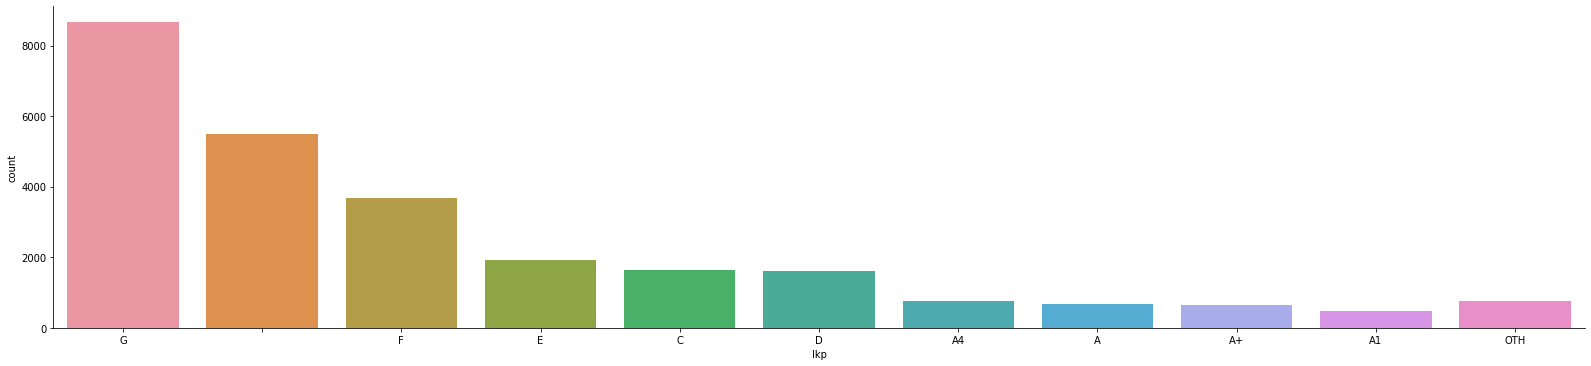

In [34]:
count_limit_plot(bologna,'classe_energetica')

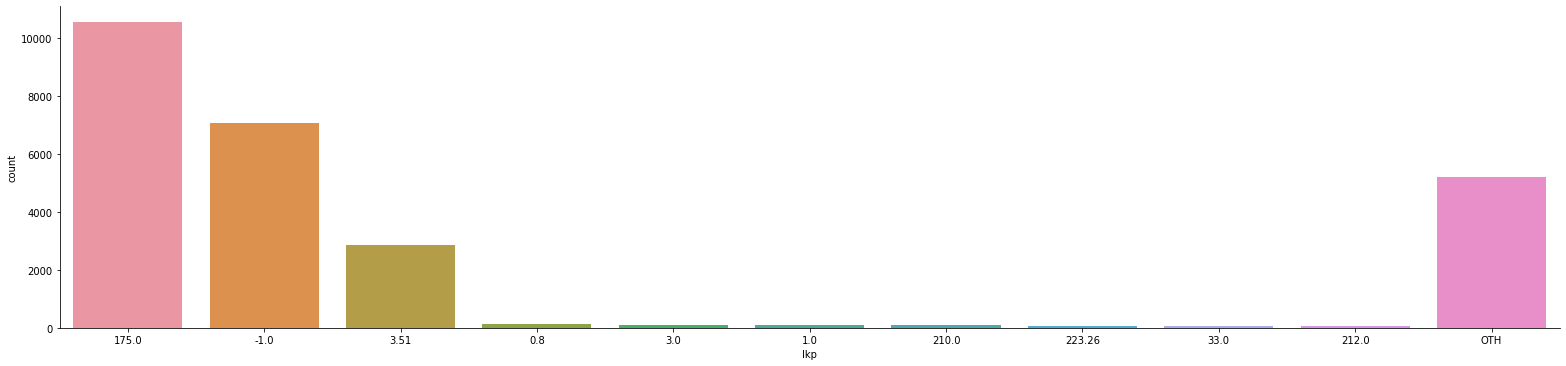

In [35]:
count_limit_plot(bologna,'kwh')

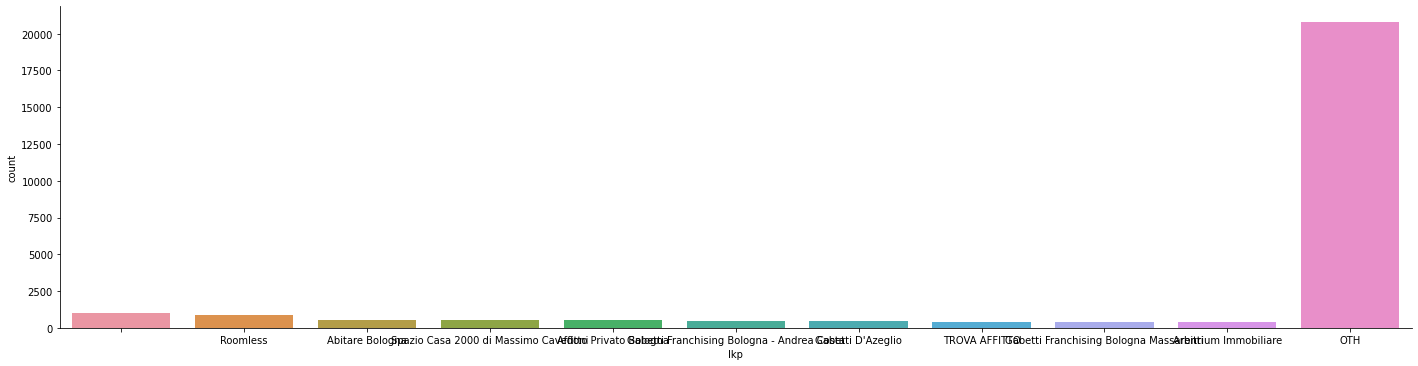

In [36]:
count_limit_plot(bologna,'agenzia')

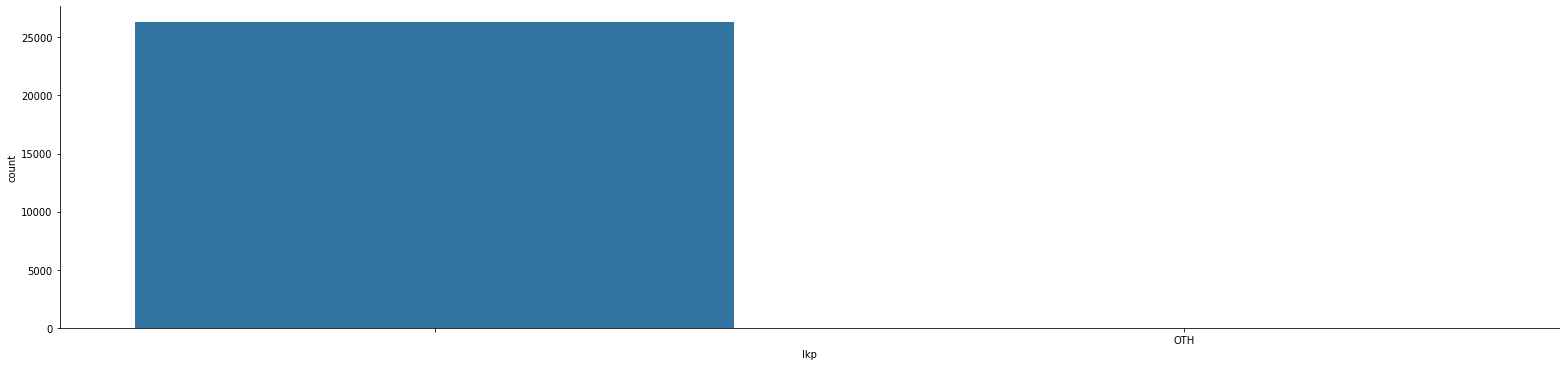

In [37]:
count_limit_plot(bologna,'inserzionista')

In [38]:
bologna_appartamento = merge_dataset.loc[(merge_dataset.comune_rga =='Bologna') & (merge_dataset.tipo_immobile =='Appartamento') & (merge_dataset.affitto == 0)]
print(bologna_appartamento.shape)
print(bologna_appartamento[['prezzo', 'superficie', 'euro_mq']].quantile([0.05, 0.95], axis = 0))
row_mask = (bologna_appartamento.prezzo.between(118000, 698000)) & (bologna_appartamento.superficie.between(40, 187))
col_mask = ['id_ann', 'data_prima_presenza_online', 'data_ultima_presenza_online', 'latitudine', 
            'longitudine', 'tipo_proprietà', 'prezzo', 'spese_condominio', 
            'superficie', 'piano', 'piani_totali', 'locali', 'climatizzato', 'bagni', 'altre_caratteristiche', 
            'anno_costruzione', 'stato', 'riscaldamento', 'climatizzazione','classe_energetica', 'kwh', 'agenzia', 'euro_mq']

(16064, 56)
        prezzo  superficie      euro_mq
0.05  119000.0        40.0  1851.851852
0.95  700000.0       184.0  5000.000000


In [39]:
bologna_appartamento_masked = bologna_appartamento.loc[row_mask, col_mask]
bologna_appartamento_masked['piani_totali'] = bologna_appartamento_masked.piani_totali.fillna(-1) 

In [40]:
bologna_appartamento_masked.columns

Index(['id_ann', 'data_prima_presenza_online', 'data_ultima_presenza_online',
       'latitudine', 'longitudine', 'tipo_proprietà', 'prezzo',
       'spese_condominio', 'superficie', 'piano', 'piani_totali', 'locali',
       'climatizzato', 'bagni', 'altre_caratteristiche', 'anno_costruzione',
       'stato', 'riscaldamento', 'climatizzazione', 'classe_energetica', 'kwh',
       'agenzia', 'euro_mq'],
      dtype='object')

Index(['G', 'A', '', 'F', 'D', 'A1', 'E', 'A2', 'A4', 'A3', 'A+', 'C', 'B'], dtype='object', name='classe_energetica')

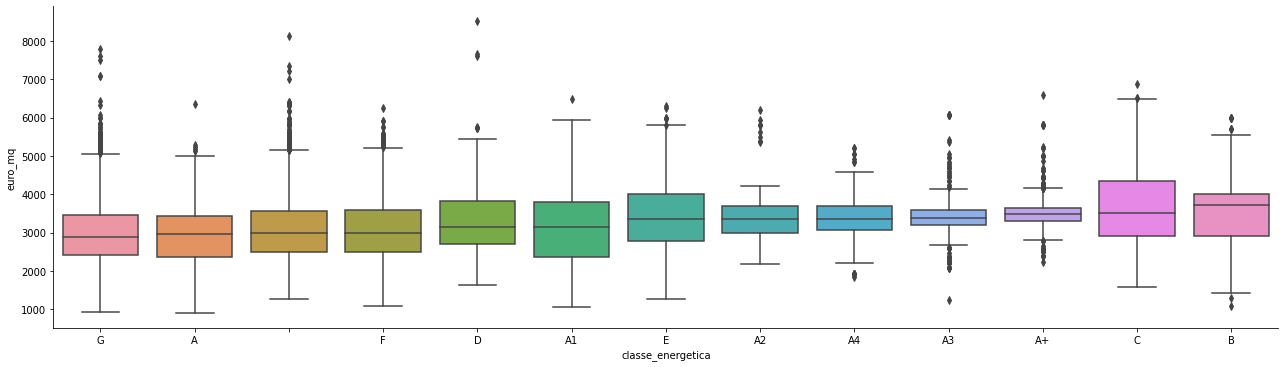

In [54]:
sns.catplot(
    x = 'classe_energetica',
    y = 'euro_mq',
    kind = 'box',
    #order = [i.strip() for i in sorted([i.ljust(2,' ') for i in bologna_appartamento_masked['classe_energetica'].unique()])],
    order = get_sorted_level(bologna_appartamento_masked, 'classe_energetica', 'euro_mq'),
    data = bologna_appartamento_masked).fig.set_size_inches(20,5)

<AxesSubplot:xlabel='locali', ylabel='euro_mq'>

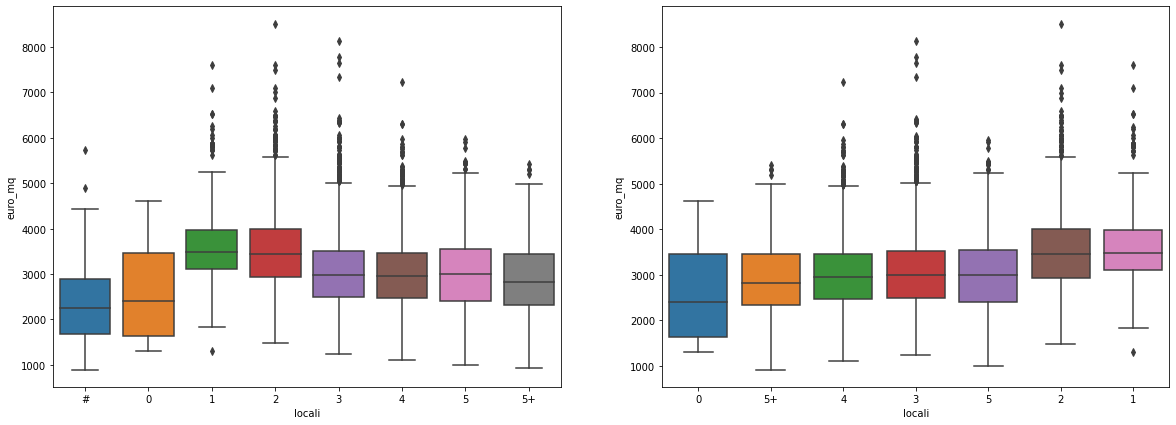

In [64]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(20,7)

sns.boxplot(
    x = 'locali',
    y = 'euro_mq',
    #kind = 'box',
    ax = ax[0],
    order = sorted(bologna_appartamento_masked['locali'].fillna('#').unique()),
    data = bologna_appartamento_masked.fillna('#'))#.fig.set_size_inches(10,10)

sns.boxplot(
    x = 'locali',
    y = 'euro_mq',
    #kind = 'box',
    ax = ax[1],
    order = get_sorted_level(bologna_appartamento_masked, 'locali', 'euro_mq'), #sorted(bologna_appartamento_masked['locali'].fillna('#').unique()),
    data = bologna_appartamento_masked.fillna('#'))

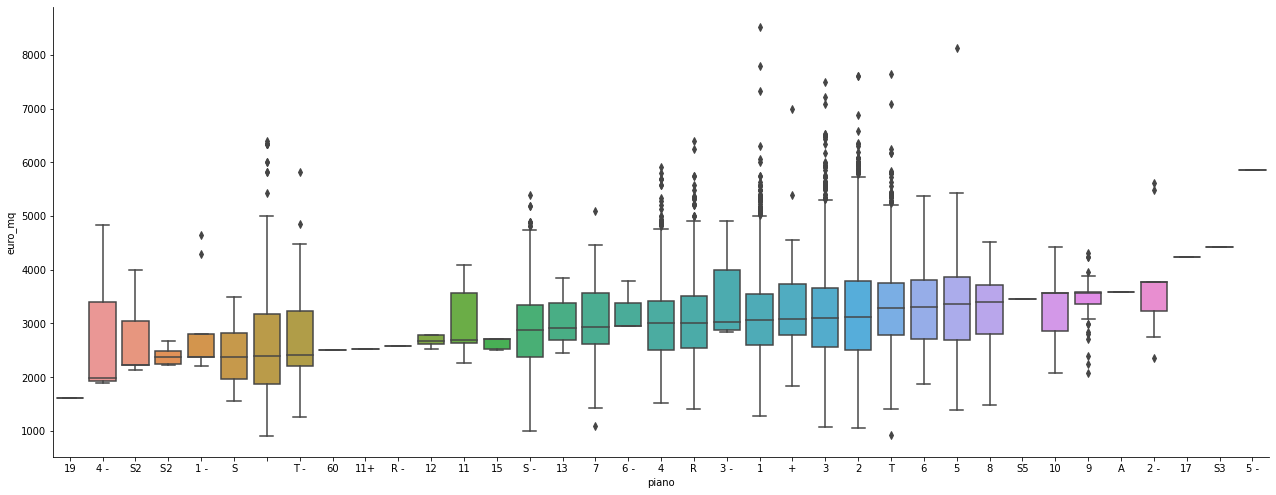

In [67]:
sns.catplot(
    x = 'piano',
    y = 'euro_mq',
    kind = 'box',
    order = get_sorted_level(bologna_appartamento_masked, 'piano', 'euro_mq'), #order = [i.strip() for i in sorted([i.ljust(2,' ') for i in bologna_appartamento.loc[row_mask]['classe_energetica'].unique()])],
    data = bologna_appartamento_masked).fig.set_size_inches(20,7)

AttributeError: 'AxesSubplot' object has no attribute 'fig'

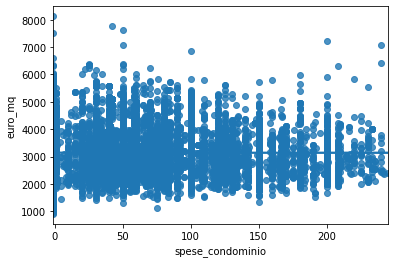

In [68]:
sns.regplot(
    x= 'spese_condominio',
    y= 'euro_mq',
    data = bologna_appartamento_masked.loc[bologna_appartamento_masked.spese_condominio<250]
)

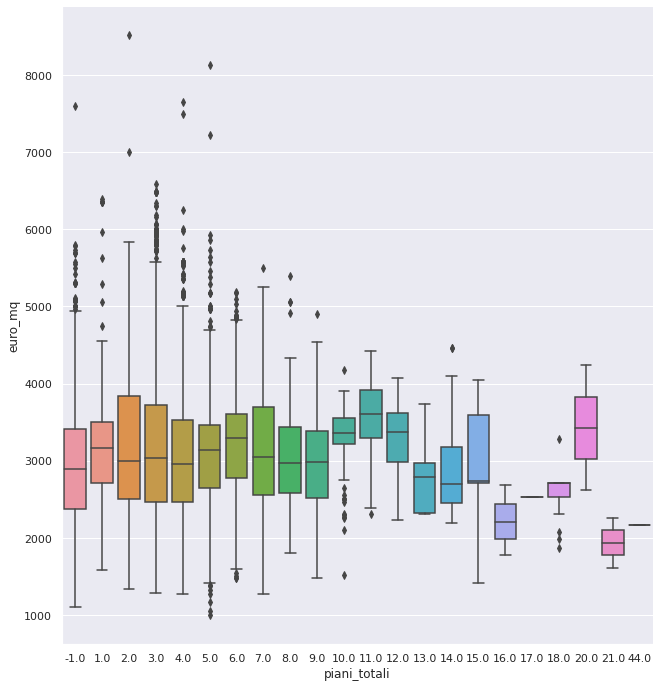

In [318]:
sns.catplot(
    x = 'piani_totali',
    y = 'euro_mq',
    kind = 'box',
    order = sorted(bologna_appartamento_masked['piani_totali'].fillna(-1).unique()),
    data = bologna_appartamento_masked.fillna(-1)).fig.set_size_inches(10,10)

In [373]:
bologna_appartamento_masked.head(2).T

,5994,6001
id_ann,5995,6002
data_prima_presenza_online,2021-08-19,2021-08-19
data_ultima_presenza_online,2022-01-05,2021-08-25
latitudine,44.4901,44.4826
longitudine,11.321,11.3781
tipo_proprietà,"Intera proprietà, classe immobile economica",Intera proprietà
prezzo,280000,120000
spese_condominio,-1,10
superficie,90,40
piano,1,T


In [69]:
bologna_appartamento_masked.data_prima_presenza_online = bologna_appartamento_masked.data_prima_presenza_online.astype('datetime64[ns]')
bologna_appartamento_masked.data_ultima_presenza_online = bologna_appartamento_masked.data_ultima_presenza_online.astype('datetime64[ns]')

In [70]:
tipo_prop_map = {i:i.split(',')[0] for i in bologna_appartamento_masked.tipo_proprietà.unique()}
bologna_appartamento_masked['tipo_proprieta_lkp'] = bologna_appartamento_masked.tipo_proprietà.map(tipo_prop_map)

<AxesSubplot:xlabel='tipo_proprieta_lkp', ylabel='euro_mq'>

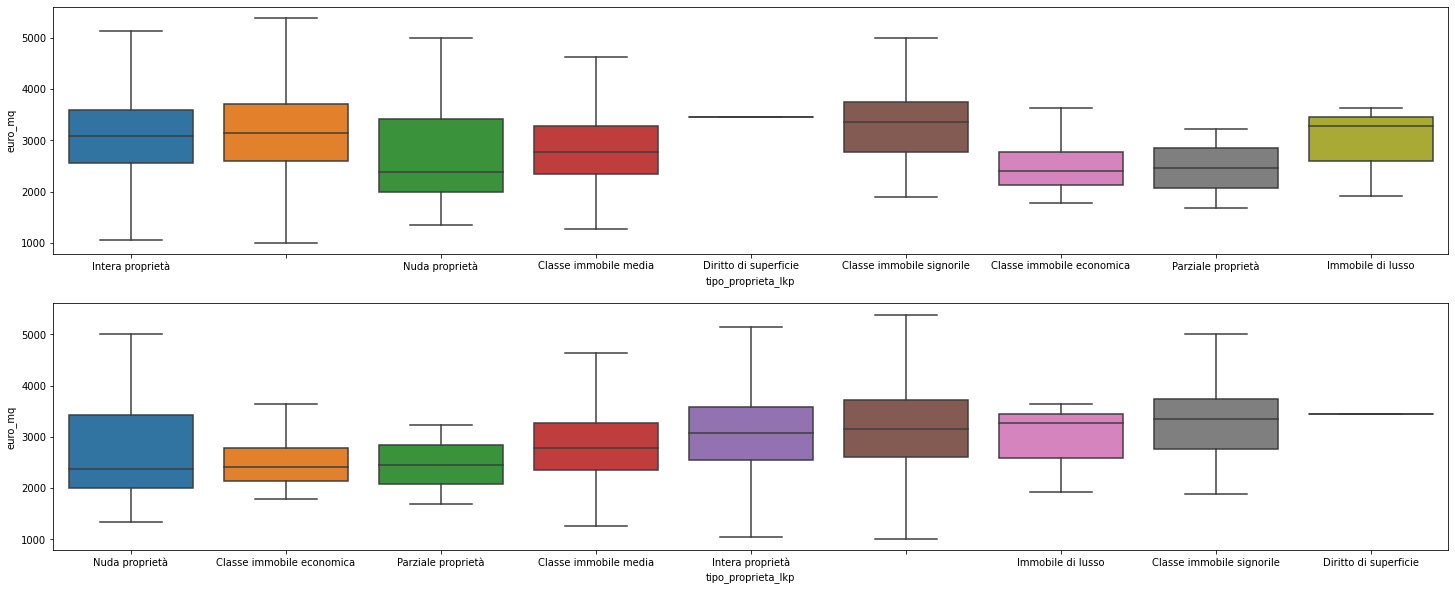

In [79]:
fig, ax = plt.subplots(2,1)

fig.set_size_inches(25, 10)

sns.boxplot(
    x = 'tipo_proprieta_lkp',
    y = 'euro_mq',
    #kind = 'box',
    ax = ax[0],
    data = bologna_appartamento_masked, 
    showfliers = False)#.fig.set_size_inches(20,5)

sns.boxplot(
    x = 'tipo_proprieta_lkp',
    y = 'euro_mq',
    #kind = 'box',
    ax = ax[1],
    order=get_sorted_level(bologna_appartamento_masked, 'tipo_proprieta_lkp', 'euro_mq'),
    data = bologna_appartamento_masked, 
    showfliers = False)

In [80]:
piano_map = {i:i.split(' ')[0] for i in bologna_appartamento_masked['piano'].unique()}
piano_map = {i:it.rjust(2,' ') if it.lower()>='a' else it.zfill(2) if it.zfill(2)<='10' else '10+' for i, it in piano_map.items()}
piano_map

{'1': '01',
 'T': ' T',
 '3': '03',
 'T -': ' T',
 '9': '09',
 '2': '02',
 'R': ' R',
 'S -': ' S',
 '4': '04',
 '7': '07',
 '': '00',
 '5': '05',
 '2 -': '02',
 'S3': 'S3',
 '8': '08',
 '6': '06',
 '10': '10',
 'S': ' S',
 '17': '10+',
 '+': '+0',
 '15': '10+',
 'S2': 'S2',
 '6 -': '06',
 'A': ' A',
 '1 -': '01',
 '4 -': '04',
 'R -': ' R',
 '12': '10+',
 '11+': '10+',
 '11': '10+',
 'S2 ': 'S2',
 '5 -': '05',
 '3 -': '03',
 'S5': 'S5',
 '19': '10+',
 '13': '10+',
 '60': '10+'}

In [81]:
bologna_appartamento_masked['piano_lkp'] = bologna_appartamento_masked.piano.map(piano_map)

In [82]:
bologna_appartamento_masked.piano_lkp.value_counts()

01     3025
02     2829
03     1912
 T     1690
04     1034
 R      920
 S      680
05      551
06      338
00      317
07      153
08       98
09       51
10+      40
+0       22
10       20
S2       11
S3        1
 A        1
S5        1
Name: piano_lkp, dtype: int64

<AxesSubplot:xlabel='piano_lkp', ylabel='euro_mq'>

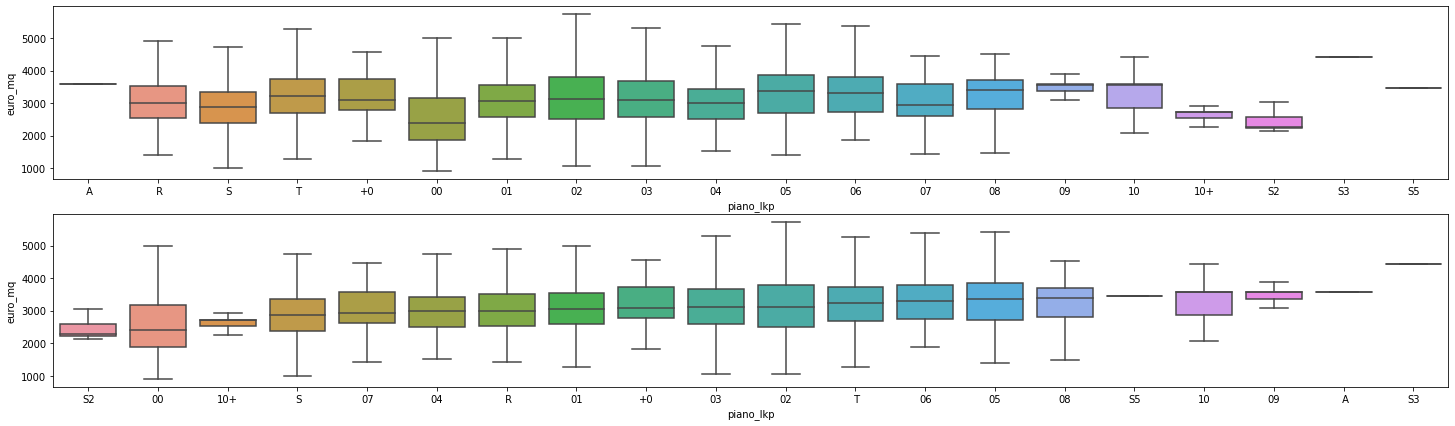

In [84]:
fig, ax = plt.subplots(2,1)

fig.set_size_inches(25, 7)

sns.boxplot(
    x = 'piano_lkp',
    y = 'euro_mq',
    order=sorted(list(set(piano_map.values()))),
    ax = ax[0],  
    data = bologna_appartamento_masked, 
    showfliers = False)

sns.boxplot(
    x = 'piano_lkp',
    y = 'euro_mq',
    order= get_sorted_level(bologna_appartamento_masked, 'piano_lkp', 'euro_mq'),
    ax = ax[1],  
    data = bologna_appartamento_masked, 
    showfliers = False)


In [85]:
piani_tot_map = {i:str(int(i)).zfill(2) if i <=10 else '10+'for i in bologna_appartamento_masked['piani_totali'].unique()}
piani_tot_map

{3.0: '03',
 -1.0: '-1',
 6.0: '06',
 4.0: '04',
 2.0: '02',
 15.0: '10+',
 1.0: '01',
 8.0: '08',
 7.0: '07',
 5.0: '05',
 9.0: '09',
 10.0: '10',
 13.0: '10+',
 18.0: '10+',
 20.0: '10+',
 14.0: '10+',
 11.0: '10+',
 12.0: '10+',
 17.0: '10+',
 16.0: '10+',
 21.0: '10+',
 44.0: '10+',
 33.0: '10+'}

In [86]:
bologna_appartamento_masked['piani_totali_lkp'] = bologna_appartamento_masked.piani_totali.map(piani_tot_map)

<AxesSubplot:xlabel='piani_totali_lkp', ylabel='euro_mq'>

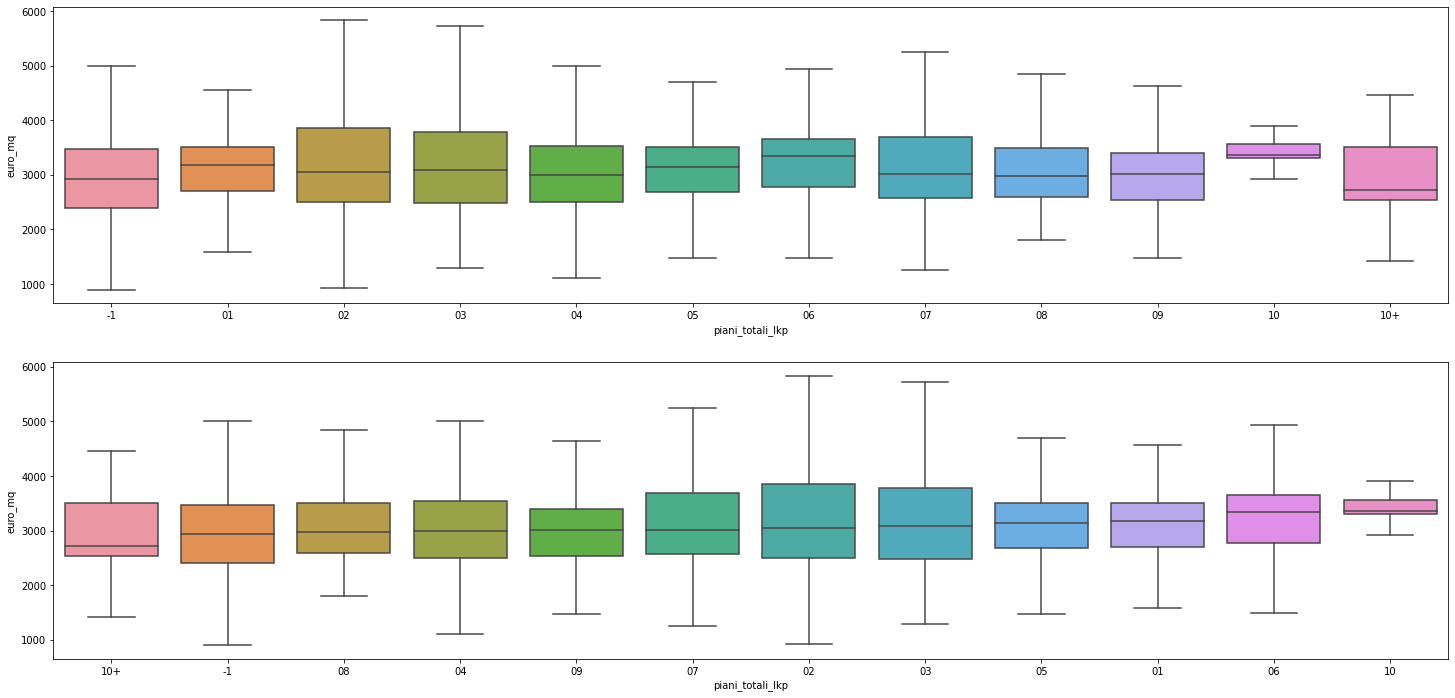

In [88]:
fig, ax = plt.subplots(2,1)

fig.set_size_inches(25, 12)

sns.boxplot(
    x = 'piani_totali_lkp',
    y = 'euro_mq',
    order=sorted(list(set(piani_tot_map.values()))), 
    data = bologna_appartamento_masked, 
    showfliers = False, 
    ax = ax[0])

sns.boxplot(
    x = 'piani_totali_lkp',
    y = 'euro_mq',
    order=get_sorted_level(bologna_appartamento_masked, 'piani_totali_lkp', 'euro_mq'), 
    data = bologna_appartamento_masked, 
    showfliers = False, 
    ax = ax[1])

In [89]:
bologna_appartamento_masked['locali_lkp'] = bologna_appartamento_masked.locali.fillna('##').apply(lambda x: x.zfill(2))

<AxesSubplot:xlabel='locali_lkp', ylabel='euro_mq'>

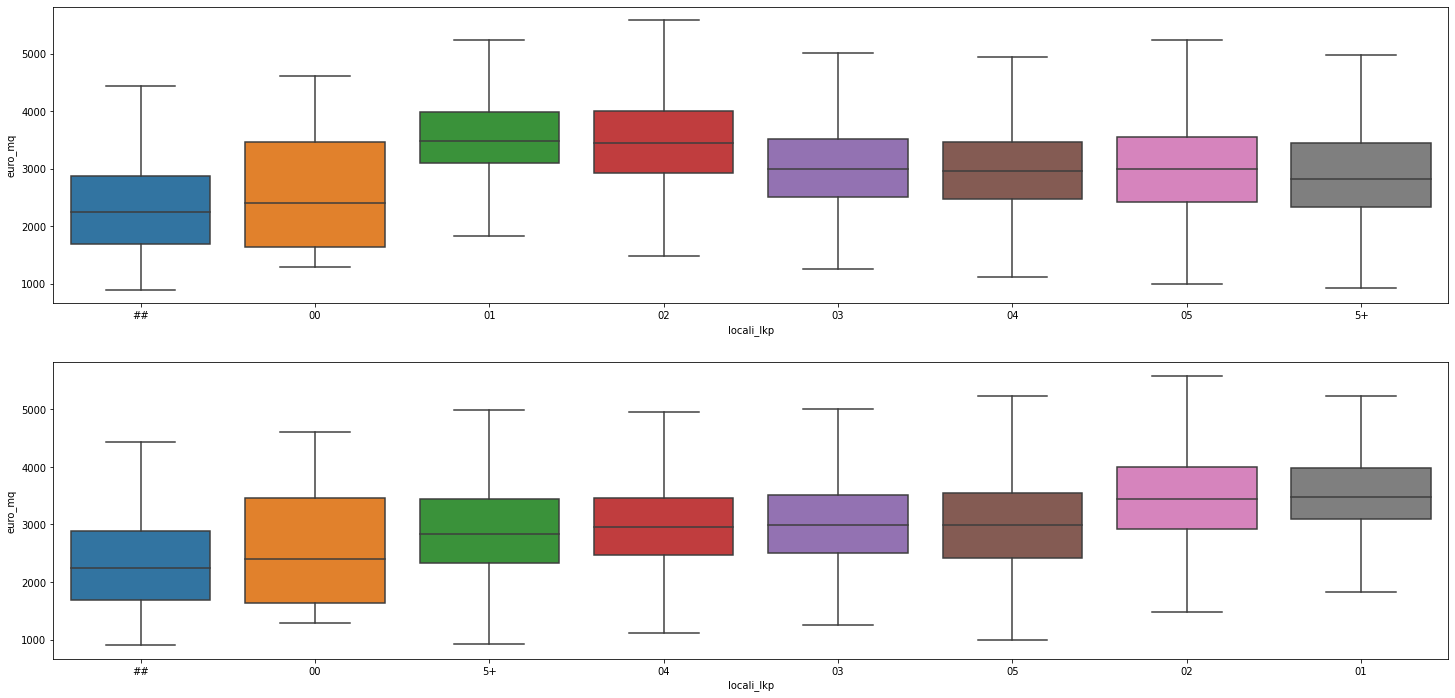

In [93]:
fig, ax = plt.subplots(2,1)

fig.set_size_inches(25, 12)

sns.boxplot(
    x = 'locali_lkp',
    y = 'euro_mq',
    order=sorted(list(set(bologna_appartamento_masked.locali_lkp))), 
    data = bologna_appartamento_masked, 
    showfliers = False, 
    ax = ax[0])

sns.boxplot(
    x = 'locali_lkp',
    y = 'euro_mq',
    order=get_sorted_level(bologna_appartamento_masked, 'locali_lkp', 'euro_mq'), 
    data = bologna_appartamento_masked, 
    showfliers = False, 
    ax = ax[1])

In [94]:
bologna_appartamento_masked['bagni_lkp'] = bologna_appartamento_masked.bagni.fillna('##').apply(lambda x: x.zfill(2))

<AxesSubplot:xlabel='bagni_lkp', ylabel='euro_mq'>

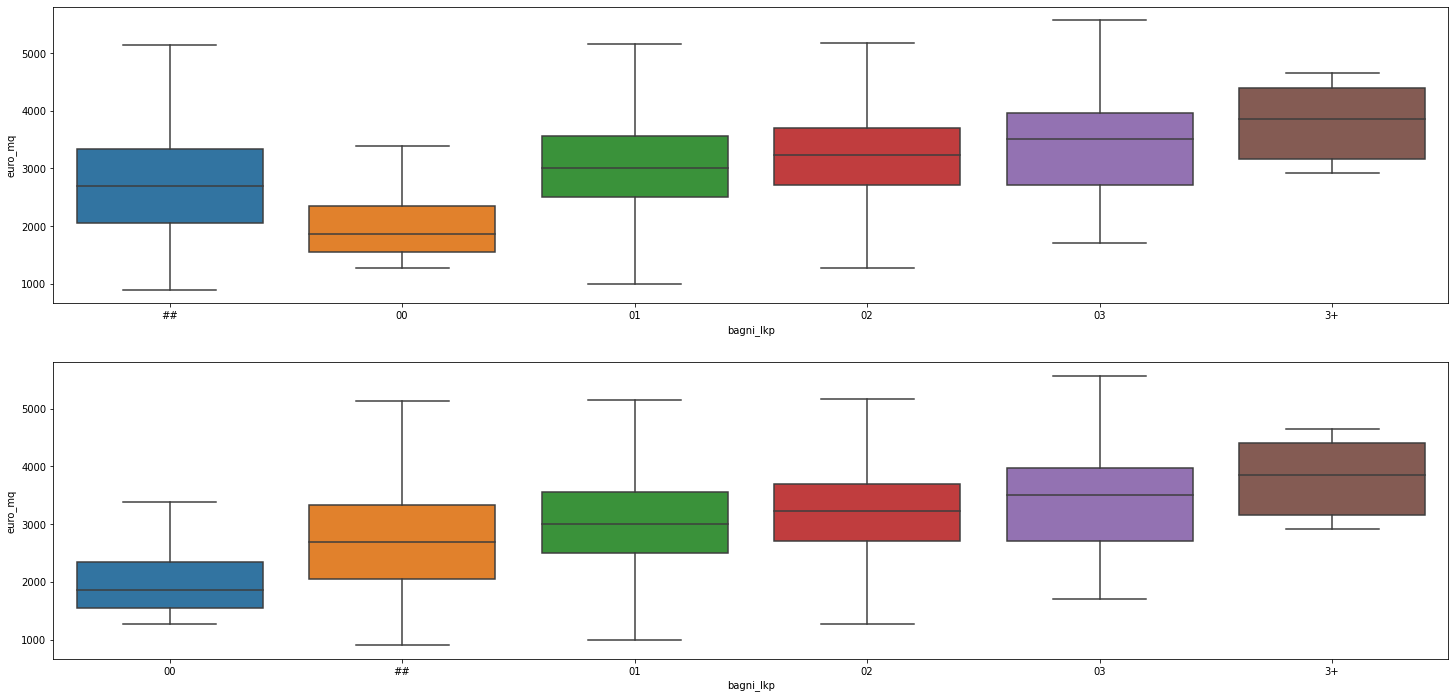

In [95]:
fig, ax = plt.subplots(2,1)

fig.set_size_inches(25, 12)

sns.boxplot(
    x = 'bagni_lkp',
    y = 'euro_mq',
    order=sorted(list(set(bologna_appartamento_masked.bagni_lkp))), 
    data = bologna_appartamento_masked, 
    showfliers = False, 
    ax = ax[0])

sns.boxplot(
    x = 'bagni_lkp',
    y = 'euro_mq',
    order=get_sorted_level(bologna_appartamento_masked, 'bagni_lkp', 'euro_mq'), 
    data = bologna_appartamento_masked, 
    showfliers = False, 
    ax = ax[1])

In [96]:
altre_caratteristiche_dict = bologna_appartamento_masked.altre_caratteristiche.apply(lambda x: {i:1 for i in x.split('|')}).to_dict()
altre_caratteristiche_exploded = pd.DataFrame(altre_caratteristiche_dict).T.fillna(0)

In [97]:
altre_caratteristiche_exploded.sum()

Balcone                                      6599.0
Cantina                                      9405.0
Arredato                                     1676.0
Giardino privato                             1095.0
                                              670.0
Terrazza                                     2936.0
Fibra ottica                                 6549.0
Impianto tv centralizzato                    7117.0
Giardino comune                              4358.0
Infissi esterni in doppio vetro / PVC        3510.0
Esposizione doppia                           4063.0
Porta blindata                               7778.0
Esposizione interna                          2410.0
Infissi esterni in vetro / legno             1443.0
VideoCitofono                                3556.0
Parzialmente Arredato                        1855.0
Cancello elettrico                           3506.0
Esposizione esterna                          3010.0
Armadio a muro                               1997.0
Solo Cucina 

In [99]:
bologna_appartamento_masked = bologna_appartamento_masked.join(altre_caratteristiche_exploded)

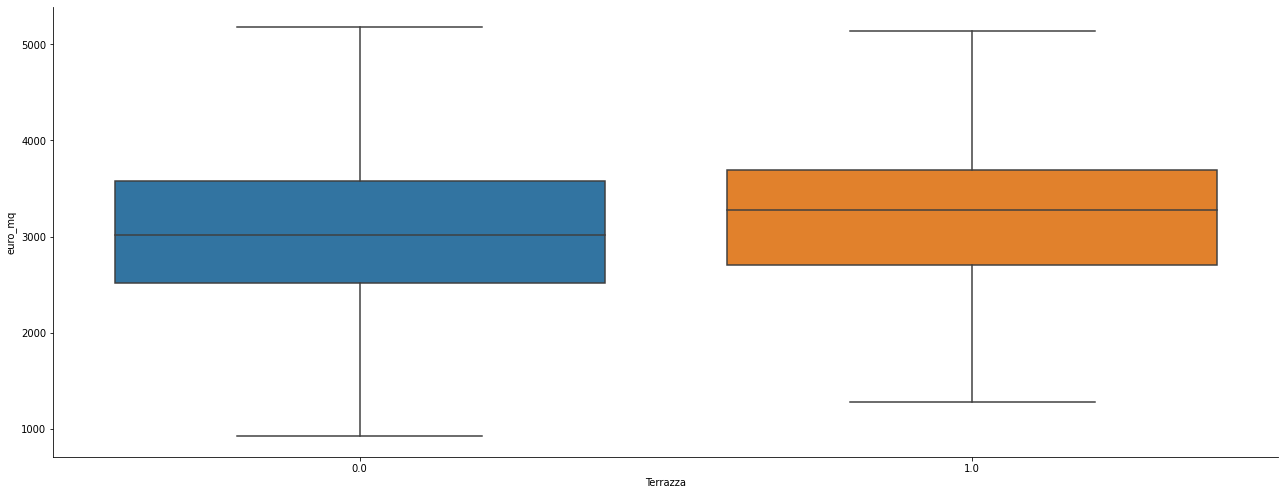

In [100]:
sns.catplot(
    x = 'Terrazza',
    y = 'euro_mq',
    kind = 'box',
    order=[0.0, 1.0],#sorted(list(set(bologna_appartamento_masked.Balcone.unique()))), 
    data = bologna_appartamento_masked, 
    showfliers = False).fig.set_size_inches(20,7)

In [101]:
bologna_appartamento_masked.stato.value_counts()

Buono / Abitabile         4514
Ottimo / Ristrutturato    4484
Nuovo / In costruzione    2325
Da ristrutturare          1397
                           745
Partecipabile              227
Non partecipabile            2
Name: stato, dtype: int64

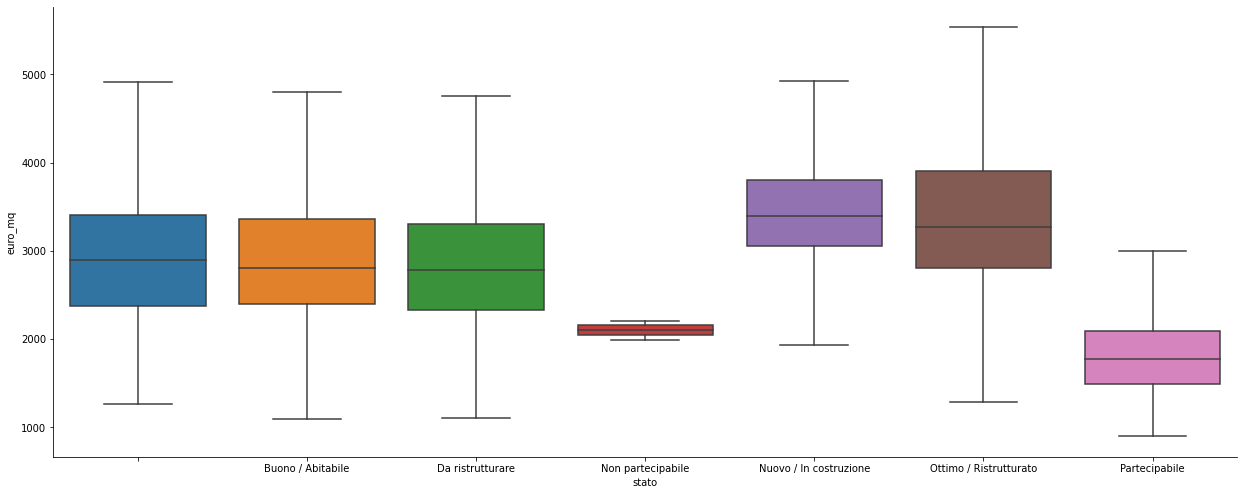

In [102]:
sns.catplot(
    x = 'stato',
    y = 'euro_mq',
    kind = 'box',
    order=sorted(list(set(bologna_appartamento_masked.stato.unique()))), 
    data = bologna_appartamento_masked, 
    showfliers = False).fig.set_size_inches(20,7)

In [108]:
bologna_appartamento_masked.riscaldamento

5994                                Autonomo, a radiatori
6001           Autonomo, a radiatori, alimentato a metano
6004                                        Centralizzato
6010                                             Autonomo
6016                                Autonomo, a radiatori
                               ...                       
260177         Autonomo, a radiatori, alimentato a metano
260179           Centralizzato, ad aria, alimentato a gas
260181    Centralizzato, a radiatori, alimentato a metano
260182    Centralizzato, a radiatori, alimentato a metano
260183    Centralizzato, a radiatori, alimentato a metano
Name: riscaldamento, Length: 13694, dtype: object

In [221]:
def normalize_riscaldamento(s):

    alim_re = re.compile('aliment')
    centr_aut_re = re.compile('autonomo|centralizzato', re.RegexFlag.IGNORECASE)

    autonomo_re = re.compile('autonomo', re.RegexFlag.IGNORECASE)

    _ret_dict = {'riscaldamento_centralizzato_cat':'', 'riscaldamento_tipo_cat':'', 'riscaldamento_alimentazione_cat':''}
    _split_val = [i.strip() for i in s.split(',')]
    #print(_split_val)

    _alim_value = list(filter(alim_re.search, _split_val))
    _centr_aut = list(filter(centr_aut_re.search, _split_val))

    if _alim_value != []:

        _alim_value = _alim_value[0]

        _split_val.remove(_alim_value)

        _alim_value = re.sub(string = _alim_value, repl='', pattern='aliment.*( a)? ', flags=re.RegexFlag.IGNORECASE)

        _ret_dict['riscaldamento_alimentazione_cat'] =  _alim_value

    if _centr_aut != []:

        _centr_aut_value = _centr_aut[0]
        _split_val.remove(_centr_aut_value)

        if autonomo_re.findall(_centr_aut_value):

            _ret_dict['riscaldamento_centralizzato_cat'] =  'NO'

        else:

            _ret_dict['riscaldamento_centralizzato_cat'] =  'SI'
    
    if _split_val != []:

        _ret_dict['riscaldamento_tipo_cat'] = _split_val[0]

    return(_ret_dict)

In [103]:
riscaldamento_dict = bologna_appartamento_masked.riscaldamento.apply(lambda x: {'riscaldamento_'+i.strip():1 for i in x.split(',')}).to_dict()
riscaldamento_exploded = pd.DataFrame(riscaldamento_dict).T.fillna(0).pipe(clean_names)
riscaldamento_exploded.sum()

riscaldamento_autonomo                          7330.0
riscaldamento_a_radiatori                       8697.0
riscaldamento_alimentato_a_metano               5900.0
riscaldamento_centralizzato                     5797.0
riscaldamento_                                   567.0
riscaldamento_alimentato_a_gas                  2358.0
riscaldamento_a_pavimento                       1167.0
riscaldamento_alimentato_a_teleriscaldamento     125.0
riscaldamento_alimentato_a_gpl                    63.0
riscaldamento_alimentato_a_gasolio                19.0
riscaldamento_alimentato_a_pompa_di_calore       466.0
riscaldamento_ad_aria                            416.0
riscaldamento_alimentato_a_fotovoltaico          192.0
riscaldamento_alimentazione_elettrica            218.0
riscaldamento_alimentato_a_solare                 20.0
riscaldamento_a_stufa                             13.0
riscaldamento_alimentato_a_pellet                  1.0
dtype: float64

In [104]:
bologna_appartamento_masked = bologna_appartamento_masked.join(riscaldamento_exploded)

In [222]:
bologna_appartamento_masked = bologna_appartamento_masked.join(
    pd.DataFrame(bologna_appartamento_masked.riscaldamento.apply(normalize_riscaldamento).to_list(), index=bologna_appartamento_masked.index))

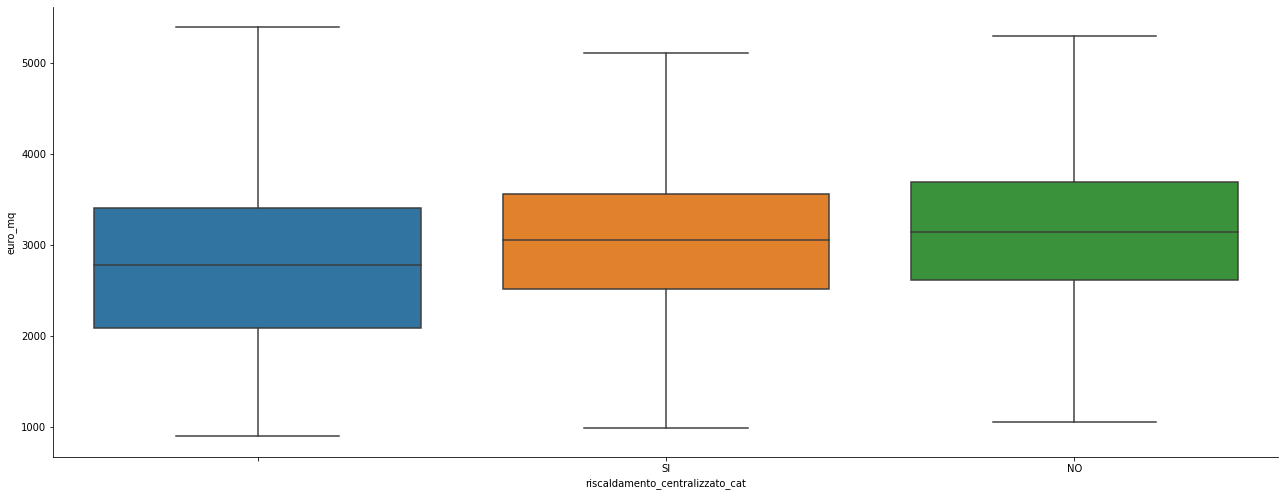

In [226]:
sns.catplot(
    x = 'riscaldamento_centralizzato_cat',
    y = 'euro_mq',
    kind = 'box',
    order=get_sorted_level(bologna_appartamento_masked, 'riscaldamento_centralizzato_cat', 'euro_mq'), 
    data = bologna_appartamento_masked, 
    showfliers = False).fig.set_size_inches(20,7)

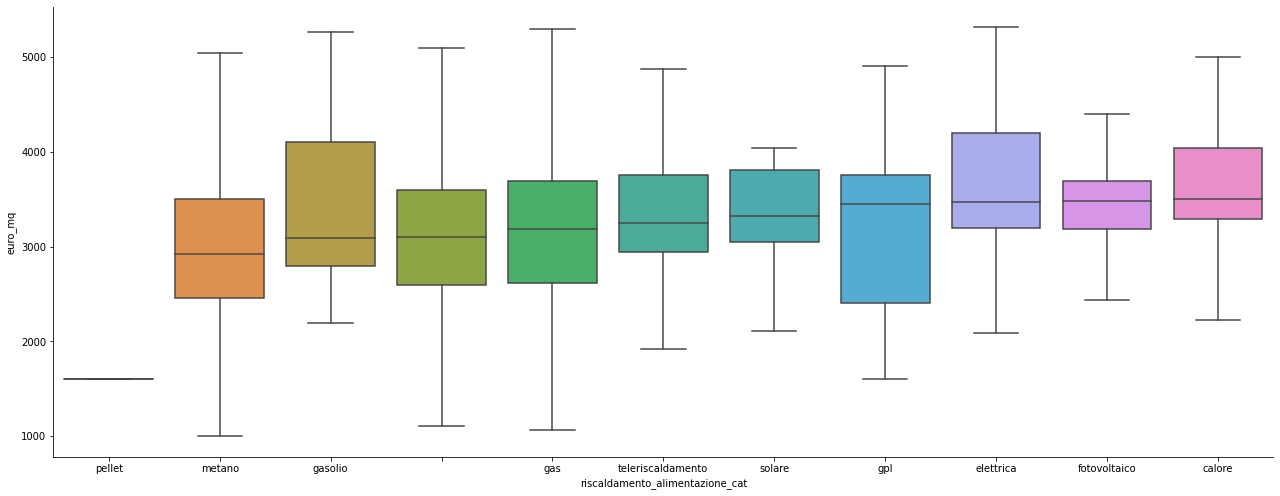

In [227]:
sns.catplot(
    x = 'riscaldamento_alimentazione_cat',
    y = 'euro_mq',
    kind = 'box',
    order=get_sorted_level(bologna_appartamento_masked, 'riscaldamento_alimentazione_cat', 'euro_mq'), 
    data = bologna_appartamento_masked, 
    showfliers = False).fig.set_size_inches(20,7)

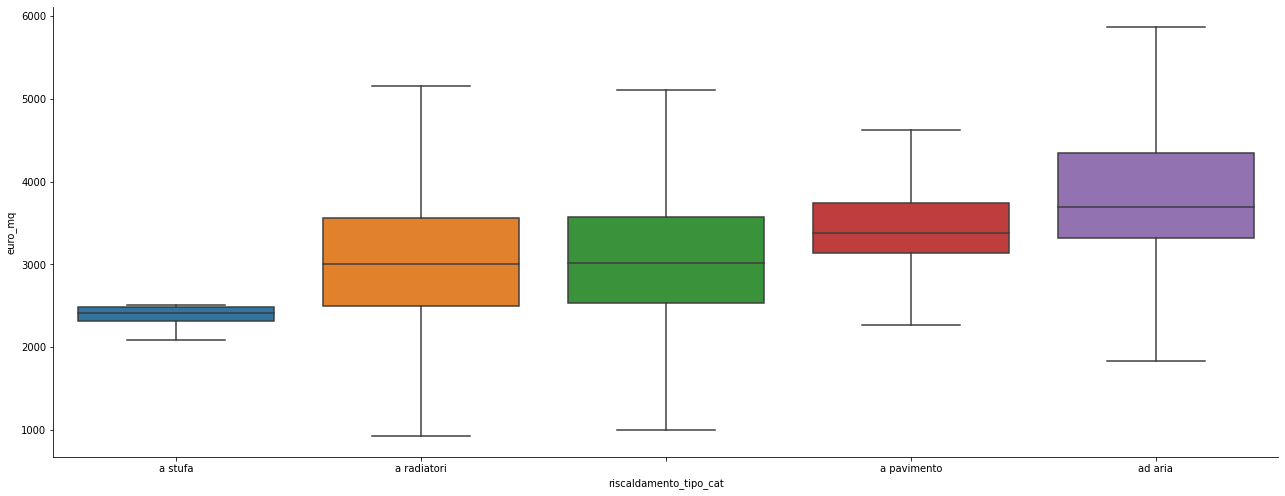

In [225]:
sns.catplot(
    x = 'riscaldamento_tipo_cat',
    y = 'euro_mq',
    kind = 'box',
    order=get_sorted_level(bologna_appartamento_masked, 'riscaldamento_tipo_cat', 'euro_mq'), 
    data = bologna_appartamento_masked, 
    showfliers = False).fig.set_size_inches(20,7)

In [505]:
climatizzazione_dict = bologna_appartamento_masked.climatizzazione.apply(lambda x: {'climatizzazione_'+i.strip():1 for i in x.split(',')}).to_dict()
climatizzazione_exploded = pd.DataFrame(climatizzazione_dict).T.fillna(0).pipe(clean_names)
climatizzazione_exploded.sum()

climatizzazione_                            6812.0
climatizzazione_autonomo                    2670.0
climatizzazione_freddo_caldo                1380.0
climatizzazione_freddo                       925.0
climatizzazione_predisposizione_impianto     352.0
climatizzazione_centralizzato                164.0
climatizzazione_freddo                        13.0
climatizzazione_caldo                          2.0
climatizzazione_freddo_caldo                  33.0
climatizzazione_assente                        6.0
dtype: float64

In [506]:
bologna_appartamento_masked = bologna_appartamento_masked.join(climatizzazione_exploded)

In [512]:
classe_energetica_map = {i:i.rjust(1,' ')[0] for i in bologna_appartamento_masked.classe_energetica.to_list()}

In [513]:
bologna_appartamento_masked['classe_energetica_lkp'] = bologna_appartamento_masked.classe_energetica.map(classe_energetica_map)

In [515]:
bologna_appartamento_masked.classe_energetica_lkp.value_counts()

G    3151
     2276
F    1699
A    1356
E     711
D     416
C     346
B      95
Name: classe_energetica_lkp, dtype: int64

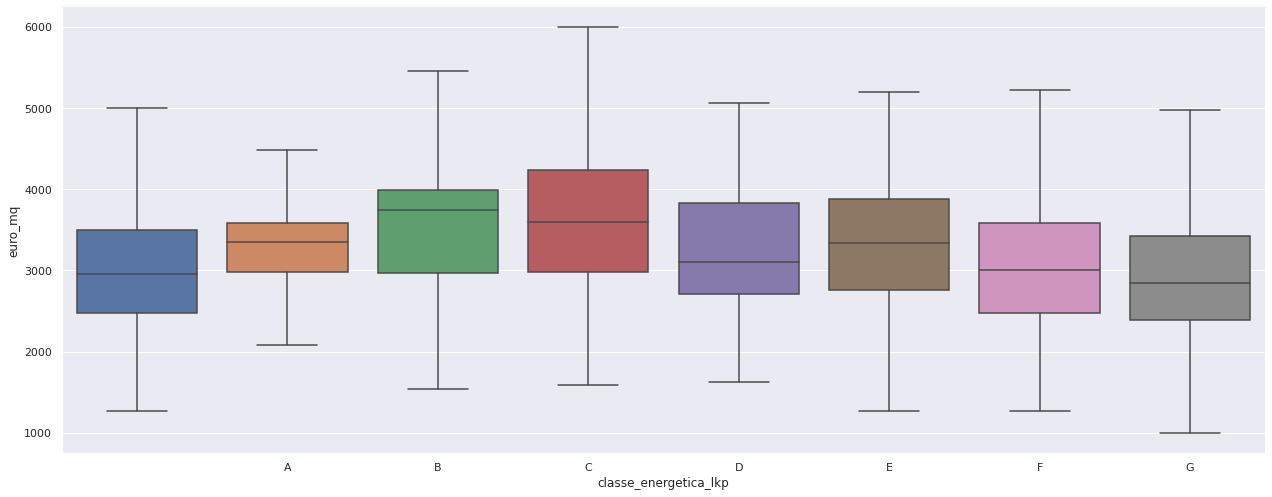

In [516]:
sns.catplot(
    x = 'classe_energetica_lkp',
    y = 'euro_mq',
    kind = 'box',
    order=sorted(list(set(bologna_appartamento_masked.classe_energetica_lkp.unique()))), 
    data = bologna_appartamento_masked, 
    showfliers = False).fig.set_size_inches(20,7)

In [529]:
bologna_appartamento_masked.drop('kwh', axis=1, inplace=True)

In [553]:
corr_matrix = round(bologna_appartamento_masked.corr(),2)

In [557]:
bologna_appartamento_masked['data_ultima_presenza_online'] - bologna_appartamento_masked['data_prima_presenza_online']

5994     139 days
6001       6 days
6004      13 days
6010     181 days
6016      22 days
           ...   
191991     0 days
191992     0 days
191993     0 days
191994     0 days
191995     0 days
Length: 10050, dtype: timedelta64[ns]

In [547]:
corr_matrix['euro_mq'].sort_values()

Balcone                            -0.25
latitudine                         -0.16
Giardino comune                    -0.15
superficie                         -0.15
Infissi esterni in vetro / legno   -0.13
                                    ... 
riscaldamento_ad_aria               0.18
Porta blindata                      0.20
VideoCitofono                       0.21
prezzo                              0.48
euro_mq                             1.00
Name: euro_mq, Length: 91, dtype: float64

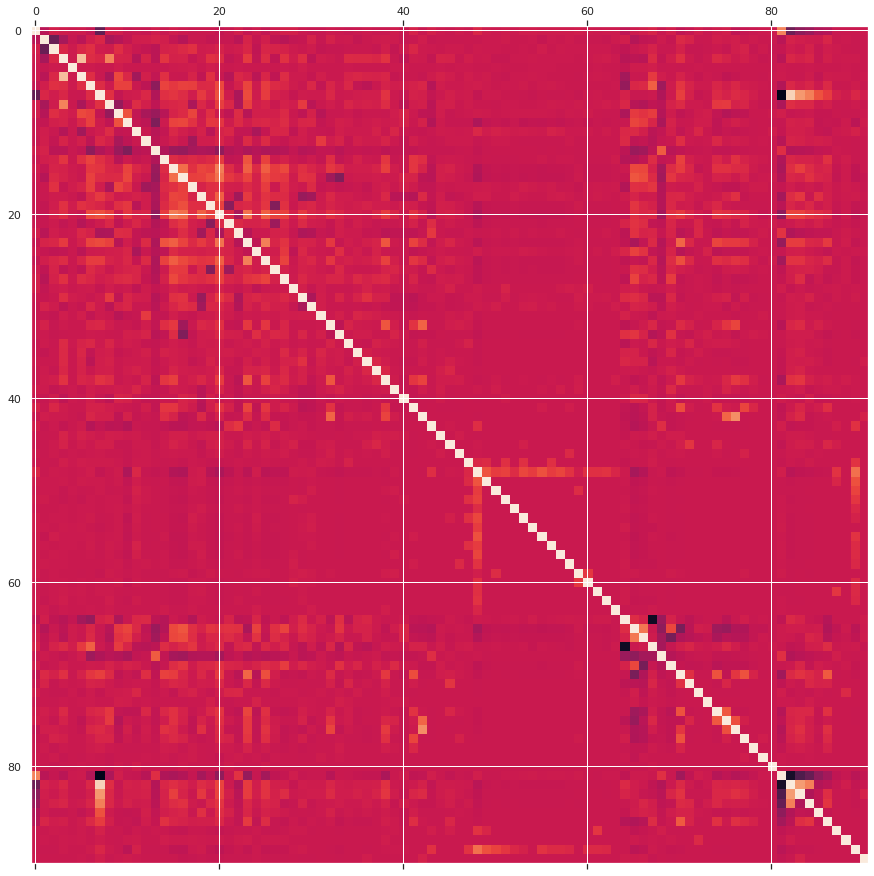

In [535]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
plt.show()